<a href="https://colab.research.google.com/github/Saba-a11/Crypto/blob/main/EWMA_%26_Holt_Winters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! ls

airline_passengers.csv	sample_data


In [2]:
import numpy as np
import pandas as pd

In [3]:
df = pd.read_csv("airline_passengers.csv", index_col="Month", parse_dates=True)

In [4]:
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [5]:
# check if there are any missing value
df.isna().sum()

Passengers    0
dtype: int64

<Axes: xlabel='Month'>

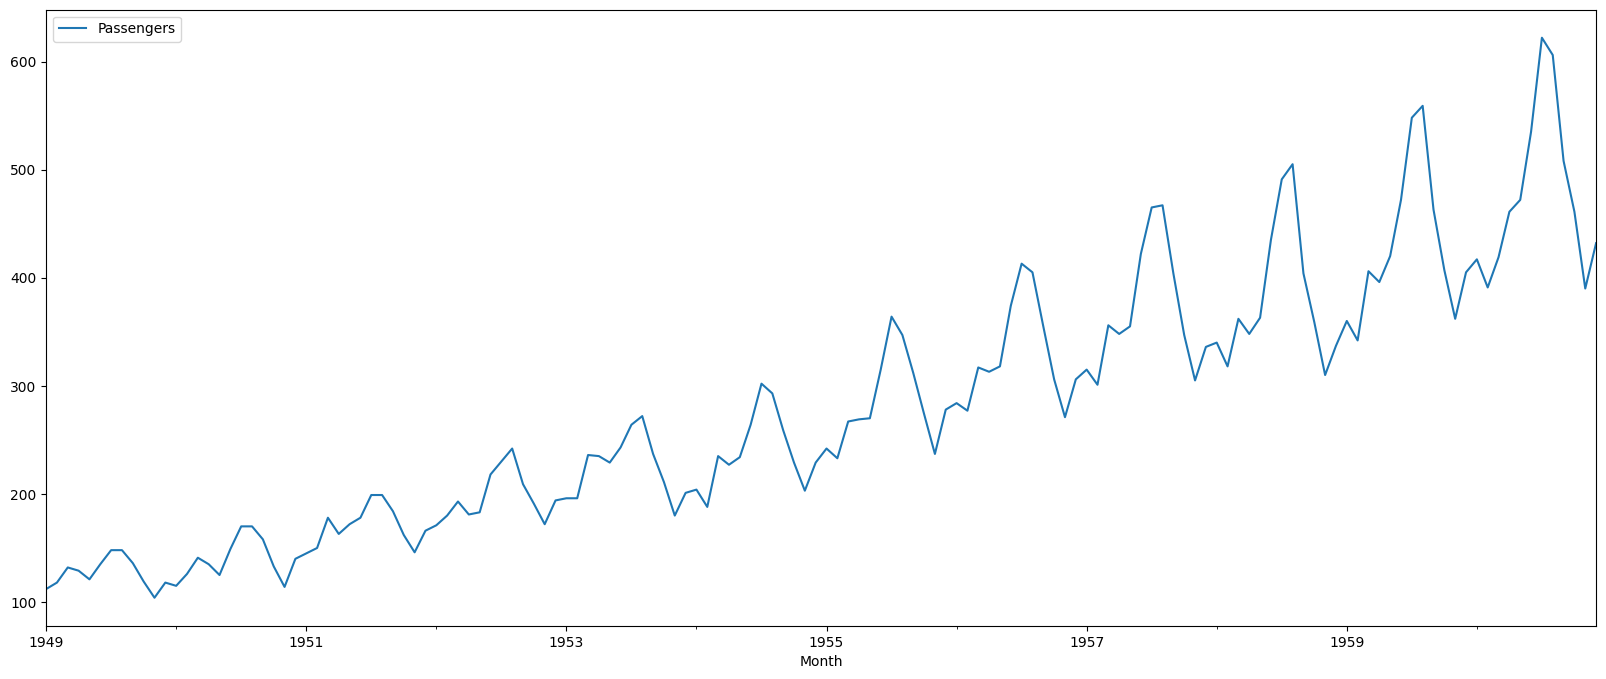

In [6]:
df.plot(figsize=(20, 8))

- This data set, there seem to be a **trend component** and **cyclical component**.

- The **trend component** means that the signal is generally going upwards.

- The **cyclical component** means that there's some periodicity where the same pattern repeats itself.

- The cyclical pattern is not a constant cyclical pattern.

- It is difficult to tell whether the trend is increasing linearly or if that is increasing over time or exponentially in time.

In [7]:
alpha = 0.2

In [8]:
df["EWMA"] = df["Passengers"].ewm(alpha=alpha, adjust=False).mean()

<Axes: xlabel='Month'>

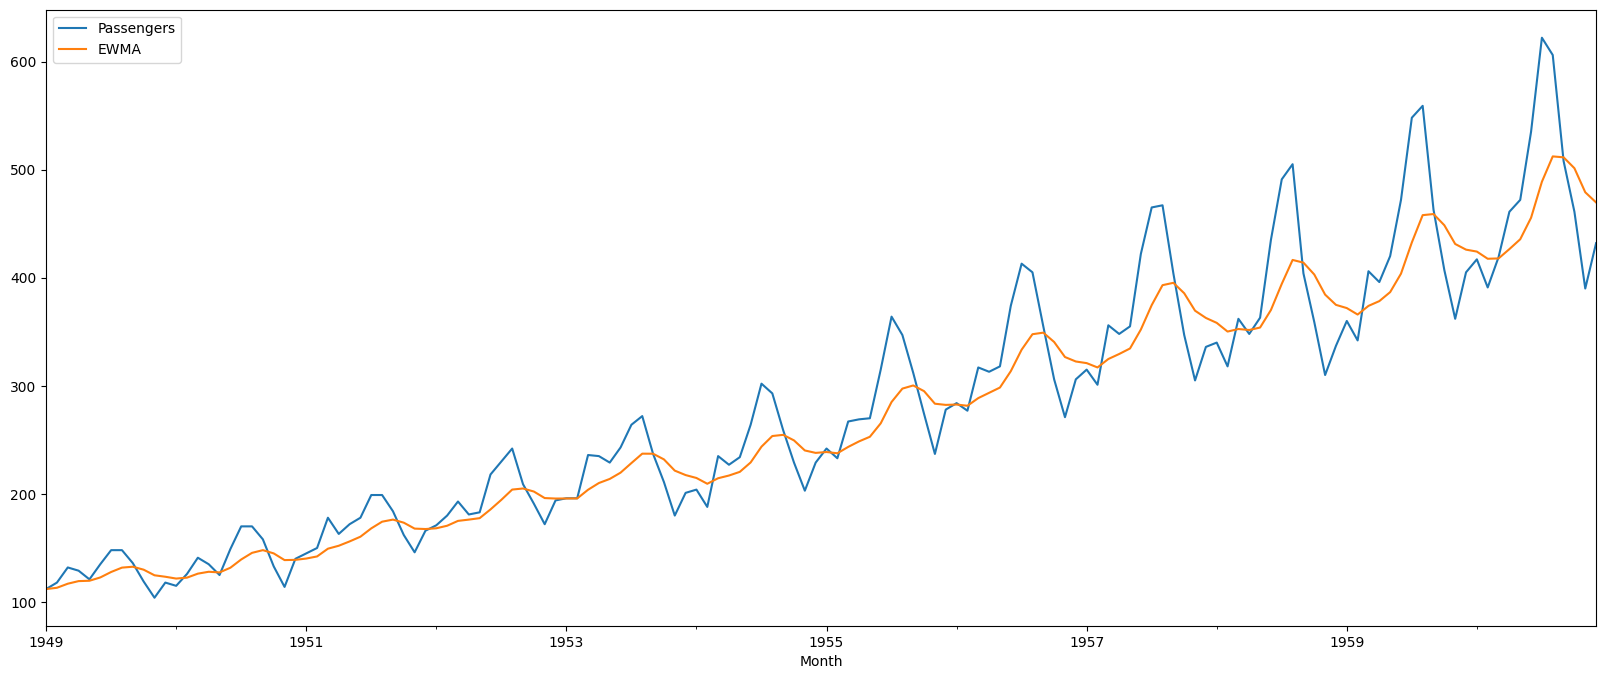

In [9]:
df.plot(figsize=(20, 8))

In [10]:
manual_ewma = []
for x in df["Passengers"].to_numpy():
  if len(manual_ewma) > 0:
    xhat = alpha * x + (1 - alpha) * manual_ewma[-1]
  else:
    xhat = x
  manual_ewma.append(xhat)

df["manual"] = manual_ewma

<Axes: xlabel='Month'>

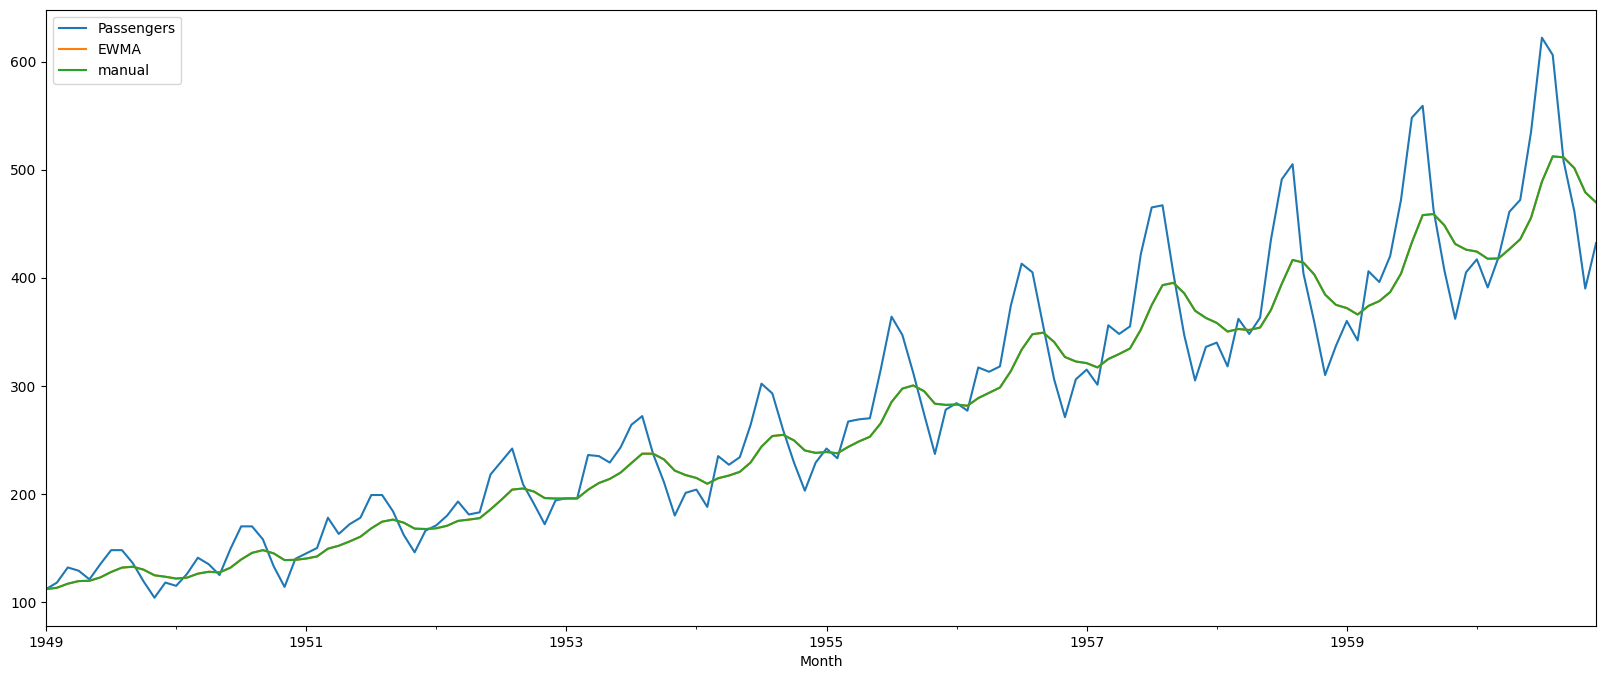

In [11]:
df.plot(figsize=(20, 8))

In [12]:
df.head()

,Passengers,EWMA,manual
Month,,,
1949-01-01,112,112.0000,112.0000
1949-02-01,118,113.2000,113.2000
1949-03-01,132,116.9600,116.9600
1949-04-01,129,119.3680,119.3680
1949-05-01,121,119.6944,119.6944


In [13]:
df.drop("manual", axis=1, inplace=True)

In [15]:
!pip install -U statsmodels

In [16]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [17]:
ses = SimpleExpSmoothing(df['Passengers'])

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [18]:
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [19]:
df.index.freq = 'MS'    # Month

In [21]:
ses = SimpleExpSmoothing(
    df['Passengers'],
    initialization_method= 'legacy-heuristic')

In [23]:
res = ses.fit(smoothing_level= alpha, optimized= False)
res

In [24]:
res.predict(start= df.index[0], end= df.index[-1])

Month
1949-01-01    112.000000
1949-02-01    112.000000
1949-03-01    113.200000
1949-04-01    116.960000
1949-05-01    119.368000
                 ...    
1960-08-01    488.767616
1960-09-01    512.214093
1960-10-01    511.371274
1960-11-01    501.297019
1960-12-01    479.037615
Freq: MS, Length: 144, dtype: float64

In [25]:
df['SES'] = res.predict(start= df.index[0], end= df.index[-1])

In [26]:
np.allclose(df['SES'], res.fittedvalues)

True

<Axes: xlabel='Month'>

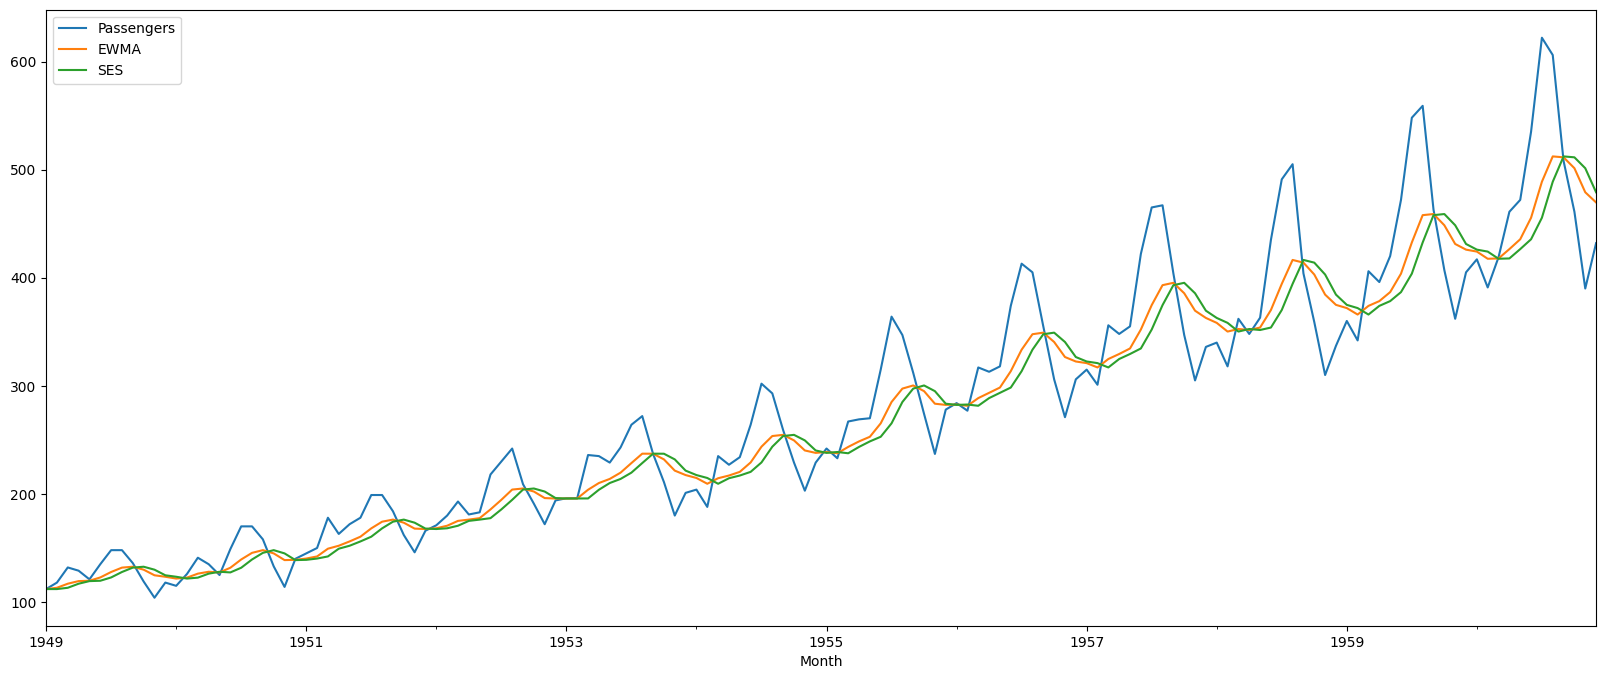

In [27]:
df.plot(figsize=(20, 8))

In [28]:
df.head()

,Passengers,EWMA,SES
Month,,,
1949-01-01,112,112.0000,112.000
1949-02-01,118,113.2000,112.000
1949-03-01,132,116.9600,113.200
1949-04-01,129,119.3680,116.960
1949-05-01,121,119.6944,119.368


In [29]:
df['SES-1'] = df['SES'].shift(-1)

<Axes: xlabel='Month'>

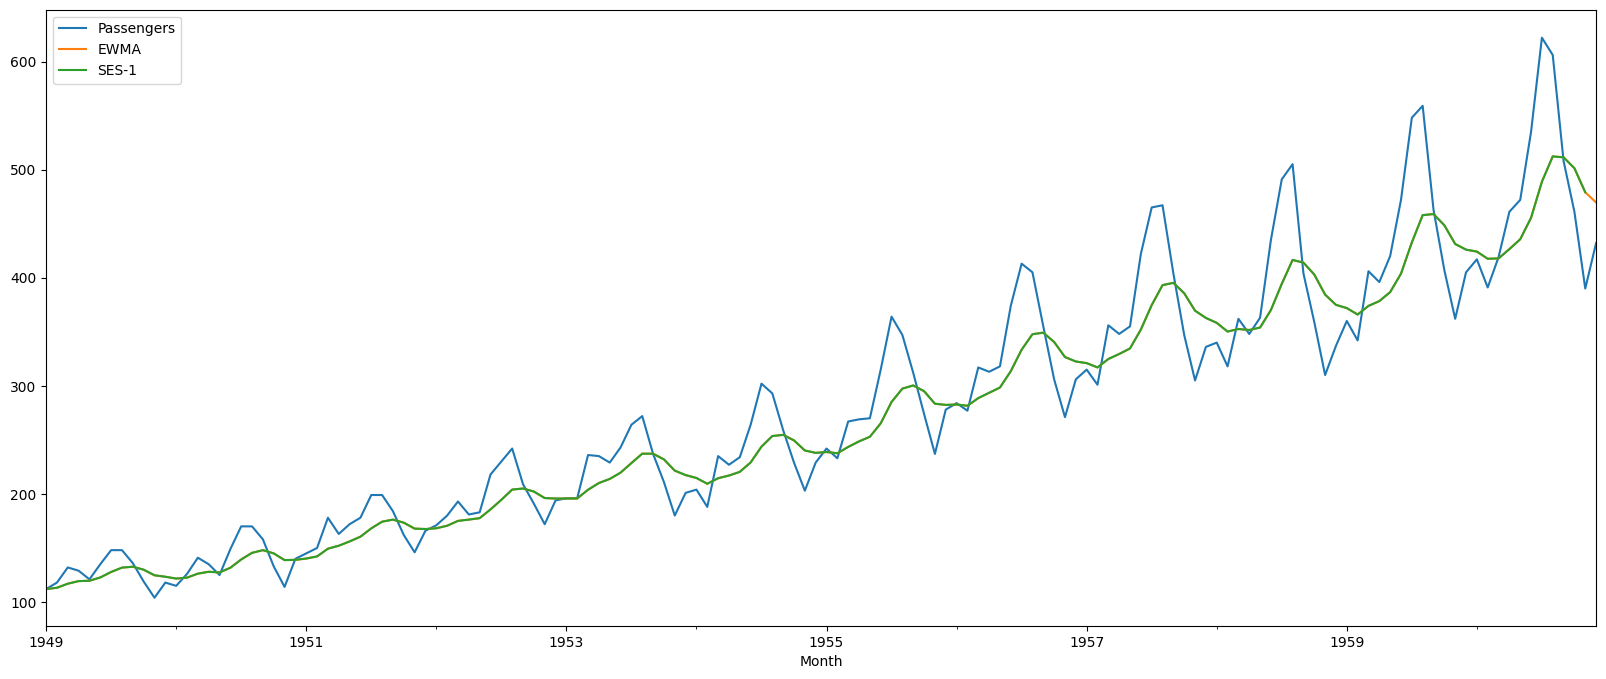

In [30]:
df[['Passengers', 'EWMA', 'SES-1']].plot(figsize= (20, 8))

In [31]:
N_test = 12
train = df.iloc[:-N_test]
test = df.iloc[-N_test: ]

In [32]:
ses = SimpleExpSmoothing(
    df['Passengers'],
    initialization_method= 'legacy-heuristic')
res = ses.fit()

In [33]:
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

<Axes: xlabel='Month'>

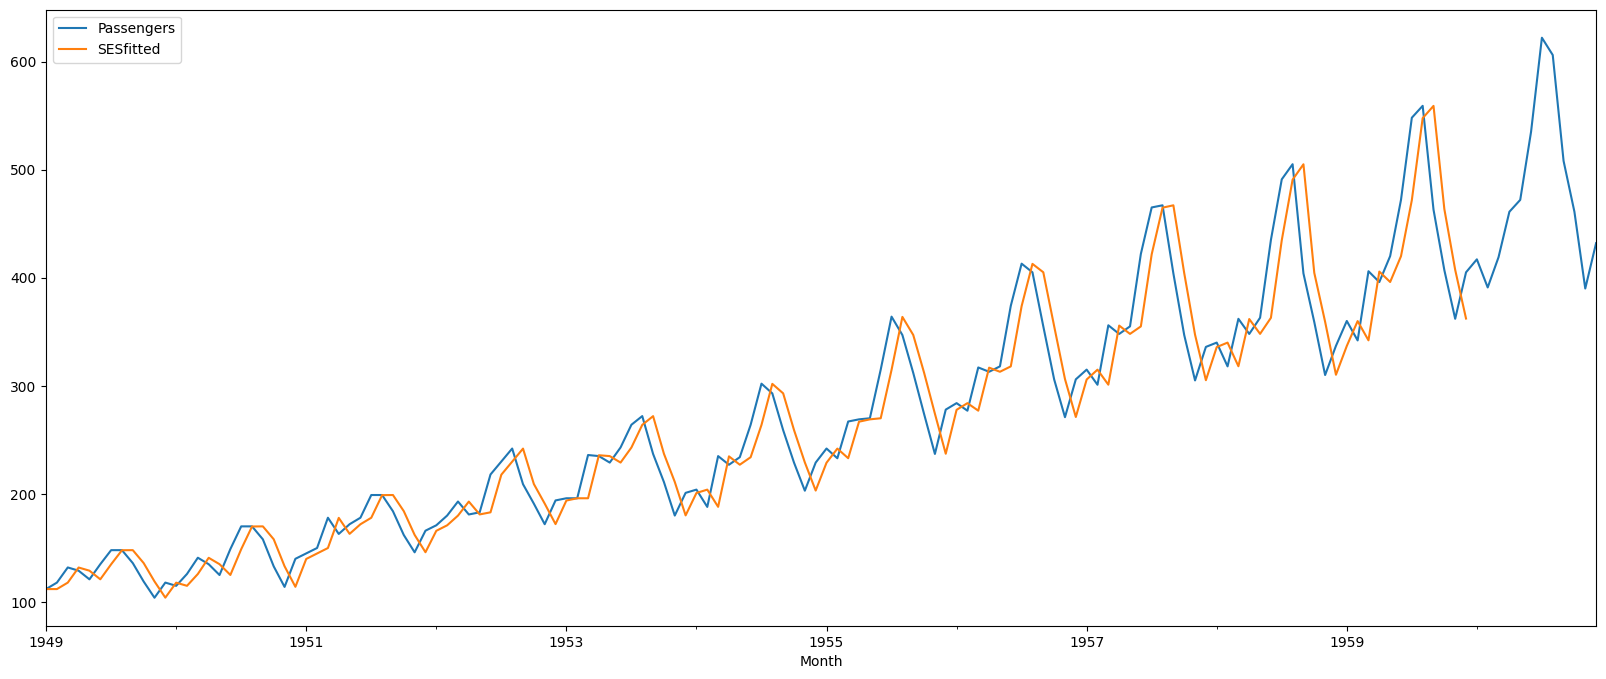

In [34]:
df.loc[train_idx, 'SESfitted'] = res.fittedvalues
df.loc[test_idx, 'SESfitted'] = res.forecast(N_test)
df[['Passengers', 'SESfitted']].plot(figsize= (20, 8))

In [35]:
res.params

{'smoothing_level': 0.995,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 112.0,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [36]:
from statsmodels.tsa.holtwinters import Holt

In [37]:
holt = Holt(
    df['Passengers'],
    initialization_method= 'legacy-heuristic')

In [38]:
res_h = holt.fit()

In [39]:
df['Holt'] = res_h.fittedvalues

<Axes: xlabel='Month'>

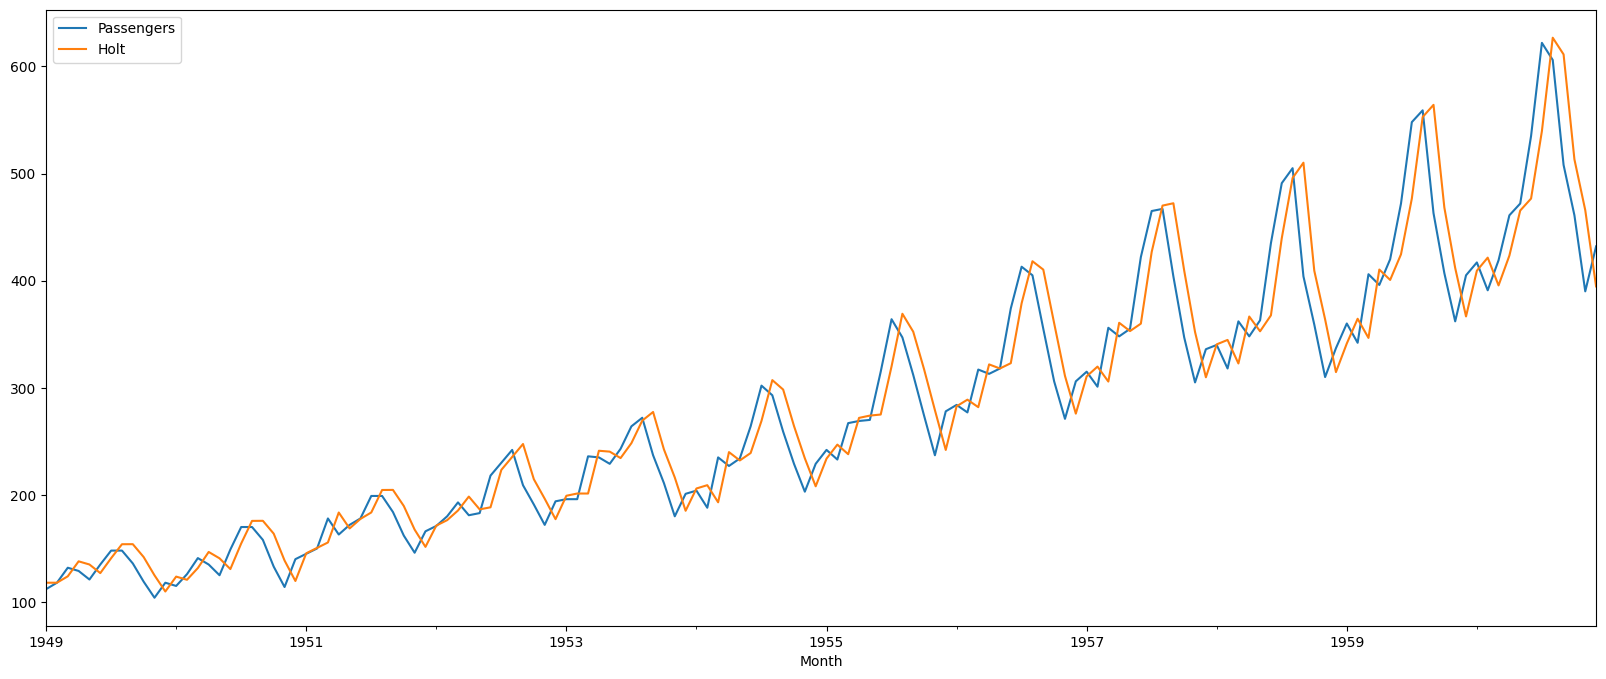

In [40]:
df[['Passengers', 'Holt']].plot(figsize= (20, 8))

<Axes: xlabel='Month'>

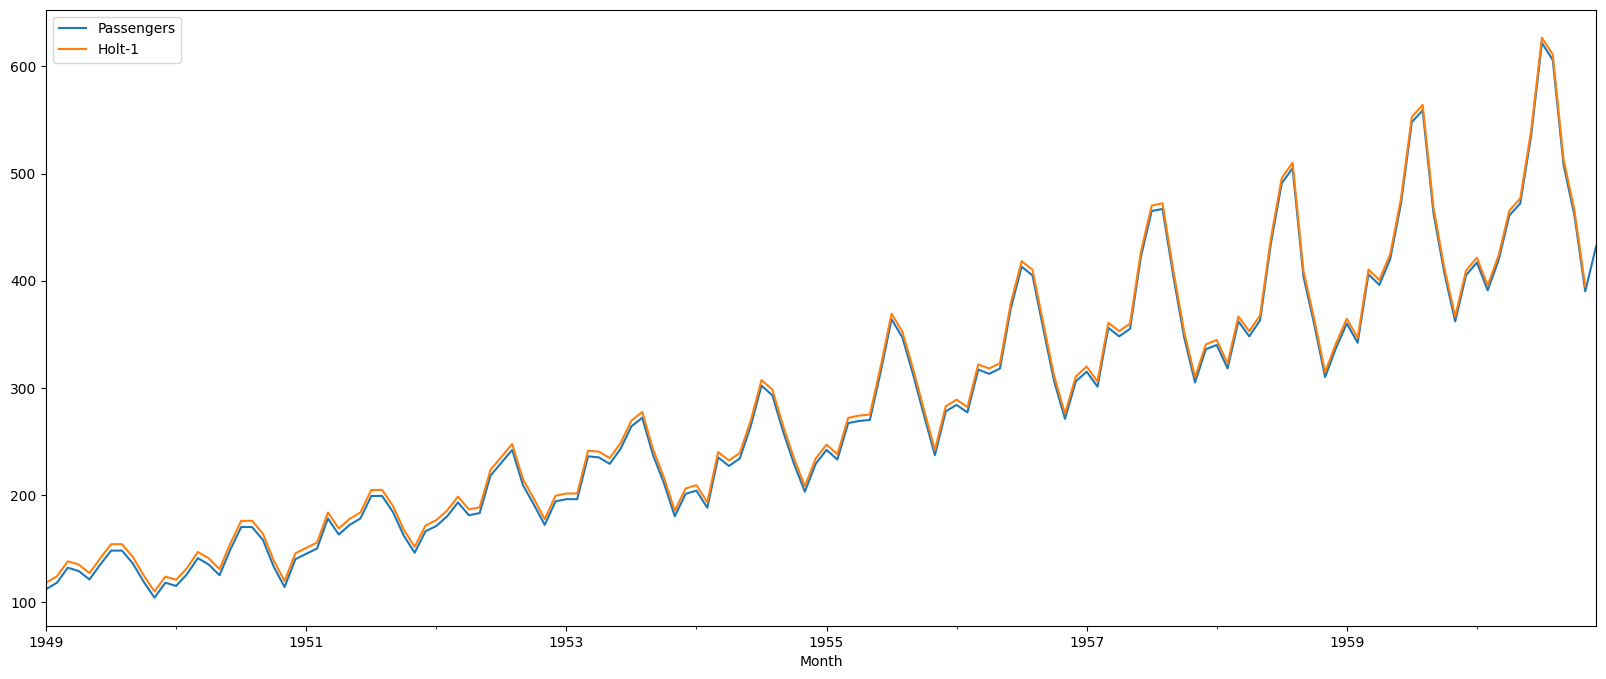

In [42]:
df['Holt-1'] = df['Holt'].shift(-1)
df[['Passengers', 'Holt-1']].plot(figsize=(20, 8))

In [43]:
holt = Holt(train['Passengers'], initialization_method='legacy-heuristic')
res_h = holt.fit()
df.loc[train_idx, 'Holt'] = res_h.fittedvalues

In [44]:
df.loc[test_idx, 'Holt'] = res_h.forecast(N_test)

<Axes: xlabel='Month'>

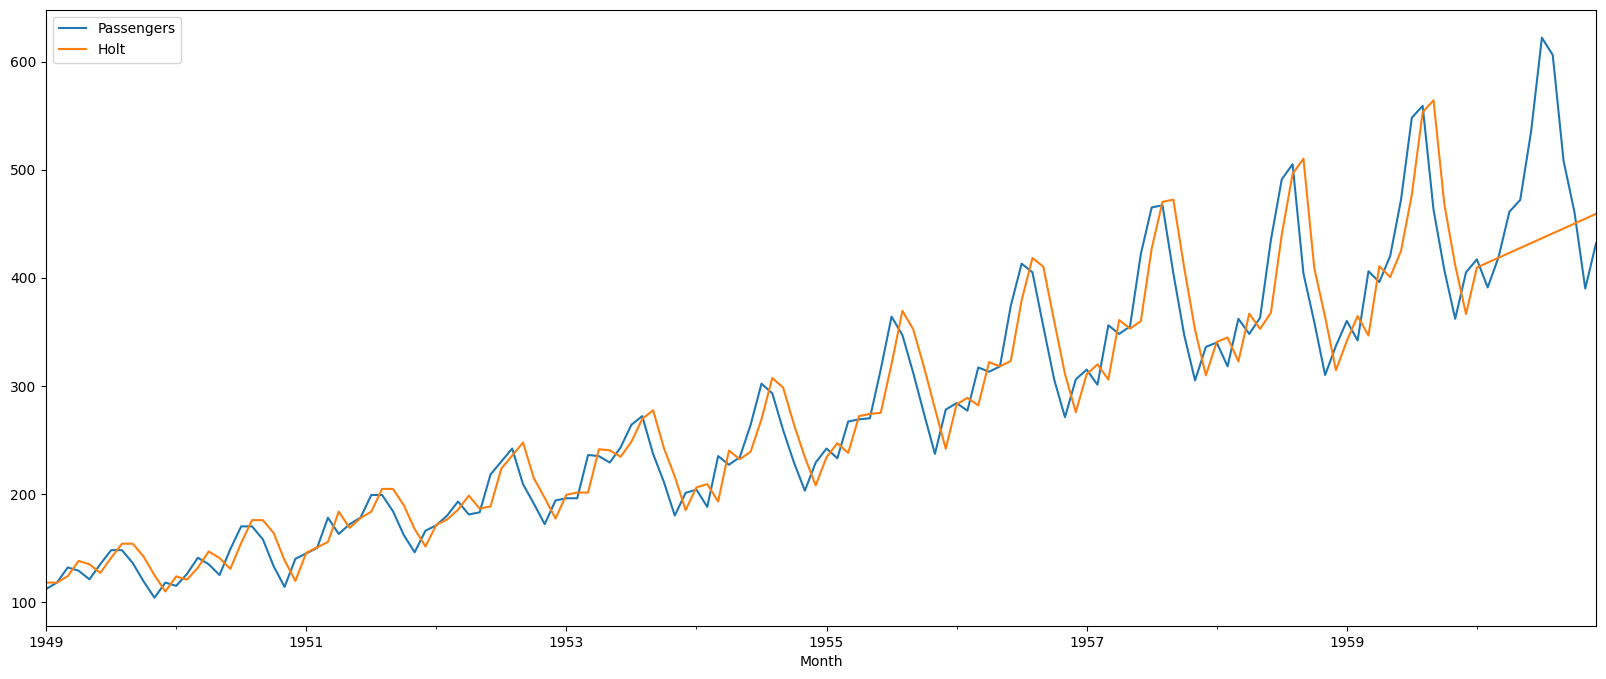

In [45]:
df[['Passengers', 'Holt']].plot(figsize=(20, 8))

In [46]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [47]:
hw = ExponentialSmoothing(
    df['Passengers'],
    initialization_method= 'legacy-heuristic',
    trend='add', seasonal='add', seasonal_periods=12)
res_hw = hw.fit()

In [48]:
df.loc[train_idx, 'HoltWinters'] = res_hw.fittedvalues
df.loc[test_idx, 'HoltWinters'] = res_hw.forecast(N_test)

<Axes: xlabel='Month'>

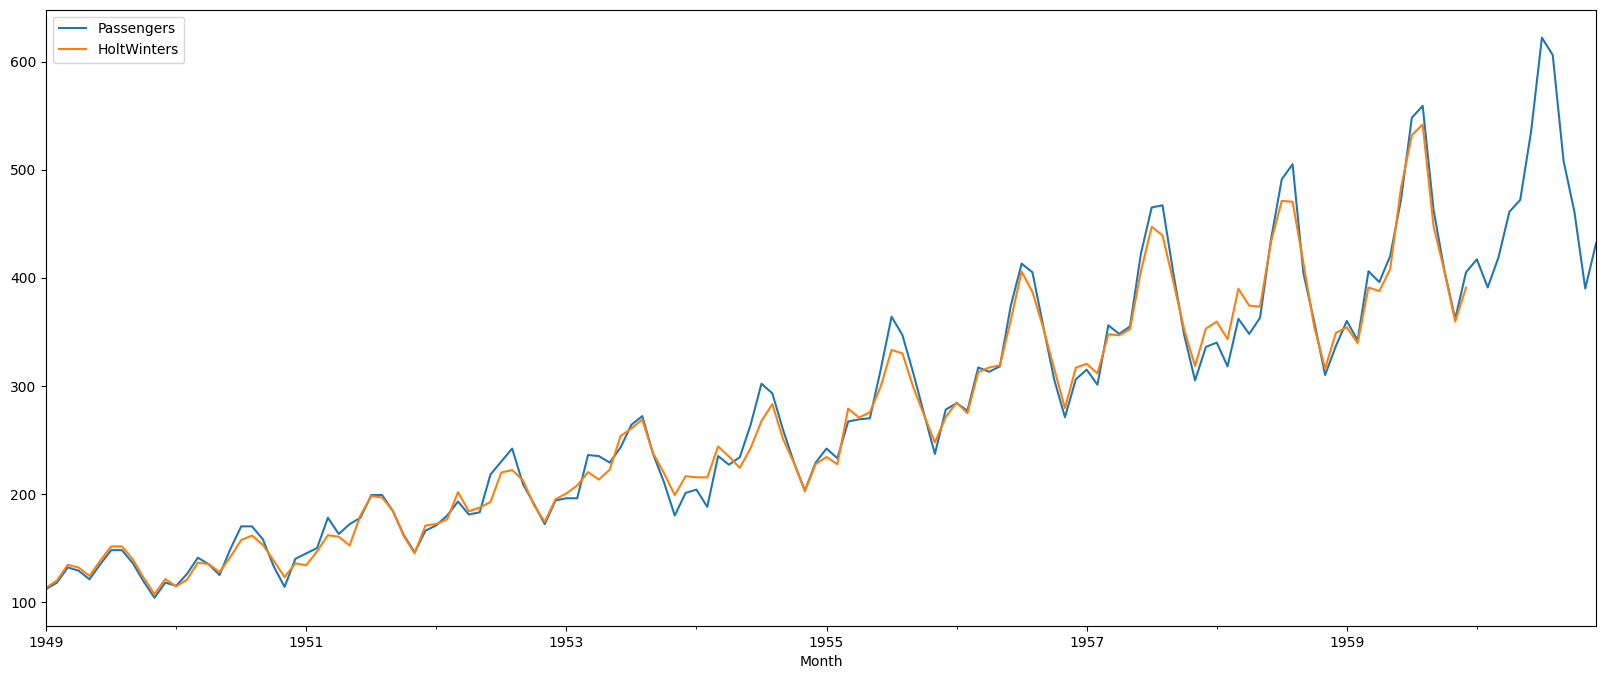

In [49]:
df[['Passengers', 'HoltWinters']].plot(figsize=(20, 8))